In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lammps_implicit_der import LammpsImplicitDer, SNAP
from lammps_implicit_der.tools import mpi_print, initialize_mpi, TimingGroup, plot_tools
from lammps_implicit_der.systems import Bcc, BccBinary

# Setup Tungsten bcc system

In [11]:
class LammpsSim(LammpsImplicitDer):
    def __init__(self):
        super().__init__()

        # Load the SNAP potential
        self.pot = SNAP.from_files('W.snapcoeff', data_path='../lammps_implicit_der/data_files/')

W_system = LammpsSim()


--------------------------------------------------------------------------------
Running LAMMPS with the following arguments:
-screen none -log none



In [16]:
num_cells = 2
alat = 3.1855
mass = 184.0
W_system.lmp.commands_string(f"""
        clear

        atom_modify map array sort 0 0.0
        boundary p p p

        # Initialize simulation
        units metal
        lattice bcc {alat} origin 0.01 0.01 0.01

        # create a block of atoms
        region C block 0 {num_cells} 0 {num_cells} 0 {num_cells} units lattice
        create_box 1 C
        create_atoms 1 region C

        mass * {mass}
""")

In [24]:
W_system.setup_snap_potential()
W_system.run_init()

Setting SNAP potential

                  SNAP coefficients for: W
 Number of parameters (excluding beta0): 55
                                Element:  W  |  R =  0.5000 w =  1.0000

Setting SNAP potential

                  SNAP coefficients for: W
 Number of parameters (excluding beta0): 55
                                Element:  W  |  R =  0.5000 w =  1.0000

Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg, fix_box_relax: False 

Number of atoms: 16, largest force value: 7.591e-15, force norm: 2.813e-14


## Basic parameters

In [18]:
print(W_system.pot.elem_list)
print(W_system.pot.Theta_dict)
print(W_system.pot.snapparam_dict)

['W']
{'W': {'elem_params': {'radius': 0.5, 'weight': 1.0}, 'beta0': -5.30602553034076, 'Theta': array([ 2.59171211e-02,  2.29459519e-02,  5.42267608e-02, -1.51585786e-02,
        2.71030824e-01,  6.53694819e-02,  3.47579854e-04, -6.36676650e-03,
        1.26170571e-01,  1.00532763e-01,  5.01645978e-02,  1.00570965e-01,
        2.52031414e-03, -2.00524259e-02,  2.86825036e-02, -6.64412013e-03,
        7.04211807e-02,  9.24840913e-02,  9.69625335e-03,  3.52187019e-02,
        9.47117594e-04,  9.90517179e-03, -1.69731525e-03,  6.53240492e-02,
        1.12288898e-01,  7.01812880e-02,  6.09595356e-02, -2.74980622e-02,
        3.72170044e-02,  5.02702975e-02,  7.06345397e-03, -1.07971357e-02,
       -2.07582090e-02,  2.41023973e-02,  9.68293034e-02,  2.74989592e-03,
        1.15041120e-02,  5.71673560e-02,  6.55507839e-03,  3.17319182e-02,
        2.12856497e-02,  1.31183642e-02,  7.55440708e-04,  7.52558175e-03,
        4.17081670e-02, -6.30345924e-03,  1.33449964e-03, -1.64835264e-04,
   

In [19]:
W_system.minimize_energy()

Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg, fix_box_relax: False 



In [20]:
W_system.X_coord

array([ 0.031855,  0.031855,  0.031855,  1.624605,  1.624605,  1.624605,
       -3.153645,  0.031855,  0.031855, -1.560895,  1.624605,  1.624605,
        0.031855, -3.153645,  0.031855,  1.624605, -1.560895,  1.624605,
       -3.153645, -3.153645,  0.031855, -1.560895, -1.560895,  1.624605,
        0.031855,  0.031855, -3.153645,  1.624605,  1.624605, -1.560895,
       -3.153645,  0.031855, -3.153645, -1.560895,  1.624605, -1.560895,
        0.031855, -3.153645, -3.153645,  1.624605, -1.560895, -1.560895,
       -3.153645, -3.153645, -3.153645, -1.560895, -1.560895, -1.560895])

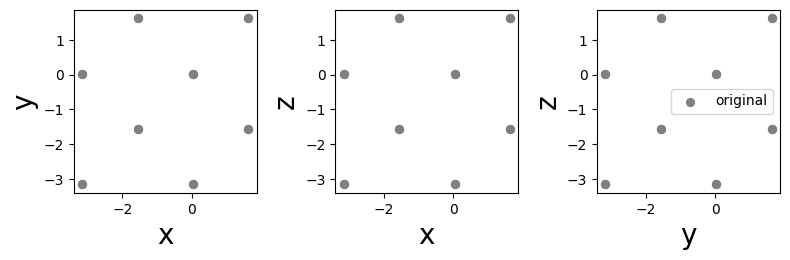

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(8, 5))
plot_tools.plot_coords(axes, W_system.X_coord.reshape(-1, 3), c='gray', s=32, label='original')
plt.tight_layout()

# Compute implicit derivative

In [25]:
W_system.scatter_coord()
W_system.gather_D_dD()
dX_dTheta = W_system.implicit_derivative(method='inverse')

Hessian: 100%|██████████| 48/48 [00:00<00:00, 109.46it/s]


In [26]:
epsilon = 0.02
M = np.diag( [epsilon, epsilon, -2.0 * epsilon]  )
W_system.apply_strain(M)

Exception: ERROR: Cannot change box tilt factors for orthogonal box (src/change_box.cpp:260)

In [ ]:
epsilon = 0.02
M = np.diag( [epsilon, epsilon, -2.0 * epsilon]  )
W_system.apply_strain(M)

Exception: ERROR: Cannot change box tilt factors for orthogonal box (src/change_box.cpp:260)